# MNIST Experimentation

This notebook involves my learning and experimenting with machine learning through the fastai and PyTorch libraries, using the MNIST dataset. I'll be writing as if my past self would read this to learn how to reproduce what I've done (though I seem to slip between I and we frequently). This is an expansion of examples used to teach the fastai library, done after I've read chapter 4 of the fastbook and watched its corresponding lesson.

In [74]:
from fastai.vision.all import *
from mnist import MNIST

It is assumed the MNIST dataset (available here: http://yann.lecun.com/exdb/mnist/) exists in a folder named "MNIST" next to the notebook, as four files (named like "t10k-images-idx3-ubyte" etc., no extension)

In [75]:
MNIST_dataset = MNIST("MNIST")

The original dataset represents each label as a number, but we want them to be represented as a PyTorch tensor of "confidences" (ranging from 0 to 1) for each digit.

In [76]:
def fixLabels(labels):
    fixed = torch.full((len(labels),10), 0.0)
    fixed[range(fixed.shape[0]), tensor(labels).long()] = 1.0
    return fixed

The mnist and fastai libraries make the data loading process very easy here. I've represented the value of each pixel as a float from 0 to 1, instead of as a ubyte as they were stored. The image comes as an array, which is what I want, unless I decide to experament with cnns. I've somewhat arbitrarily chosen a batch size of 256 and shuffled the data.

Unimportant Aside: I think using a batch size that's a multiple of 64 (or 32) might be more efficient for computation, based solely and naively on this: https://stackoverflow.com/questions/63034523/difference-between-calling-numthreads-and-dispatch-in-a-unity-compute-shader. No clue if I'm right, but from what I've seen it seems like a reasonable batch size anyway (a fastai tutorial on a smaller version of this dataset used 256 as the batch size as well), so no harm done. I also doubt it matters much in this case, but maybe it would for models which need longer training times.

In [360]:
images,labels = MNIST_dataset.load_training()
train_dset = list(zip(tensor(images).float()/255, fixLabels(labels)))

images,labels = MNIST_dataset.load_testing()
valid_dset = list(zip(tensor(images).float()/255, fixLabels(labels)))

train_dl = DataLoader(train_dset, 256, shuffle=True)
valid_dl = DataLoader(valid_dset, 256, shuffle=True)

dls = DataLoaders(train_dl, valid_dl)

## Linear Model

The first model I wanted to make was a purely linear model, aiming for similar results cited on the mnist dataset website linked above, which scored an error rate of 12%. Since this means the output of the model can be outside the 0 to 1 range, I decided to use sum of squares error as the loss function. I initially used abs error loss, but sum of squares loss seems to train faster initially (I believe due to larger gradients for absolute errors greater than .5), as well as performing much better overall, since the absolute error loss seemed to improve to 66% accuracy and then decrease most times.

In [361]:
def sumSquaresLoss(preds, targets):
    return (preds-targets).square().sum(-1).mean()

I create my own accuracy metric by finding the proportion of the time the index of the max confidence is the same in both the predicted and targeted tensors, i.e. the proportion of the time the model guessed the correct number.

In [362]:
def maxMatchAccuracy(preds, targets):
    _,pred_labels = preds.max(-1)
    _,target_labels = targets.max(-1)
    return (pred_labels==target_labels).sum()/preds.shape[0]

At this point, creating and training the model is very easy. All I have to do is plug in what I've made, choose a learning rate (by trial and error on a small number of epochs), and run fit().

In [363]:
learner = Learner(dls, nn.Linear(28*28, 10), loss_func=sumSquaresLoss, metrics=maxMatchAccuracy, lr=.0001)
learner.fit(10)

epoch,train_loss,valid_loss,maxMatchAccuracy,time
0,0.571646,0.517043,0.805400,00:00
1,0.463303,0.443777,0.844400,00:00
2,0.430774,0.421162,0.857900,00:00
3,0.419162,0.410207,0.857400,00:00
4,0.410808,0.403126,0.859400,00:00
5,0.407405,0.399388,0.860100,00:00
6,0.403406,0.396126,0.860900,00:00
7,0.402204,0.393376,0.859100,00:00
8,0.398603,0.391923,0.857500,00:00
9,0.393160,0.389967,0.858400,00:00


After only a few epochs, the model seems to always get down to a 14% error rate, similar to the 12% error rate achieved by someone who knew what they were doing! Just for fun, I'll take a look at the weights. It won't be a complete picture since we don't know the cutoff point where activations are negative for each image, but it should be interesting to look at.

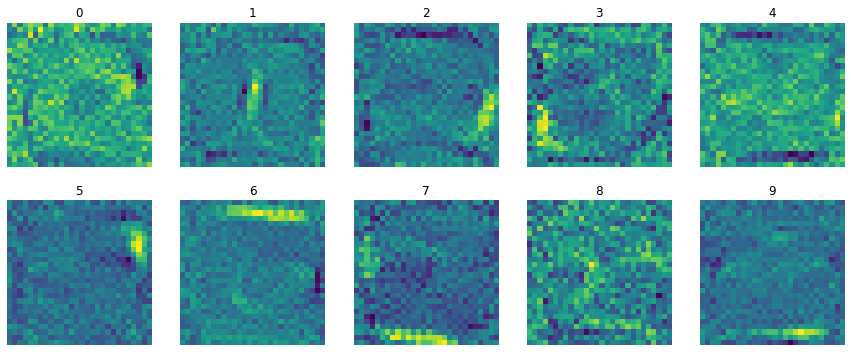

In [364]:
weights,_ = list(learner.model.parameters())
ims = weights.view(10,28,28)
show_images(ims, titles=range(10), nrows=2)

## Adding complexity to the model

Those were good results, but I'd like to focus next on improving the model by adding complexity for the model to work with. I'll start with a ReLU layer (arbitrarily) with a softmax layer on the end, since it would be nice to have the model's predictions be between 0 and 1, and since I think forcing the confidences to add to 1 would encourage the model to be more decisive in it's predictions. I think adding the softmax layer will also allow me to swap out the loss function for one more fitting (and with larger gradients near correct predictions than the old one), so I'll do that. I'll also change how labels are represented for memory efficiency, changing them back to how they came.

In [365]:
images,labels = MNIST_dataset.load_training()
train_dset = list(zip(tensor(images).float()/255, tensor(labels).long()))

images,labels = MNIST_dataset.load_testing()
valid_dset = list(zip(tensor(images).float()/255, tensor(labels).long()))

train_dl = DataLoader(train_dset, 256, shuffle=True)
valid_dl = DataLoader(valid_dset, 256, shuffle=True)

dls = DataLoaders(train_dl, valid_dl)

def maxMatchAccuracy(preds, targets):
    _,pred_labels = preds.max(-1)
    return (pred_labels==targets).sum()/preds.shape[0]

Now onto the new loss function:

In [440]:
def diffLoss(preds, targets):
    return 1 - preds[range(preds.shape[0]),targets].mean()

And now we're ready to try out the new model! I decided to make the hidden layer 20 neurons, since I doubt more than 20 features will be useful (20 is probably too much in my intuition).

In [435]:
learner = Learner(dls, nn.Sequential(nn.Linear(28*28, 20), nn.ReLU(), nn.Linear(20,10), nn.Softmax()),
                  loss_func=diffLoss, metrics=maxMatchAccuracy, lr=.0005)
learner.fit(20)

epoch,train_loss,valid_loss,maxMatchAccuracy,time
0,0.413394,0.346823,0.724600,00:00
1,0.249757,0.212121,0.845900,00:00
2,0.155935,0.144195,0.895700,00:00
3,0.126647,0.120344,0.907000,00:00
4,0.114878,0.108053,0.913500,00:00
5,0.103758,0.101478,0.917000,00:00
6,0.101924,0.096005,0.919500,00:00
7,0.096811,0.092115,0.922000,00:00
8,0.090423,0.089046,0.923400,00:00
9,0.088441,0.086838,0.924300,00:00


This one seems to get varying results, but given a bit of luck it frequently achieves an error rate around 7%! We halved the error rate! Let's take a look at the features we learned in the hidden layer:

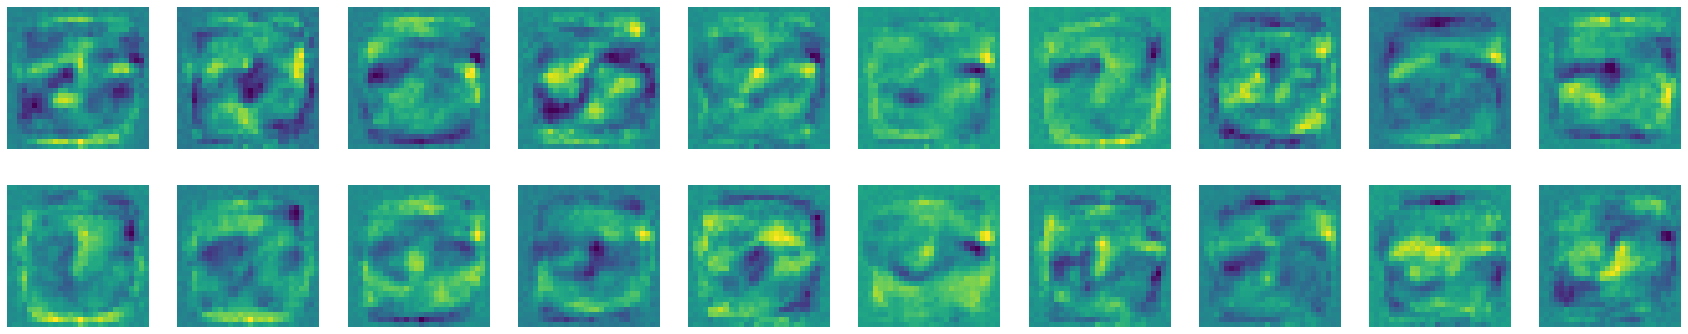

In [436]:
weights,biases,weights2,_ = list(learner.parameters())
ims = (weights.transpose(0,1)+biases).transpose(0,1).view(20,28,28)
show_images(ims, nrows=2)

Not much I can glean from that, but at least all of the features seem to be looking for... something. I wonder if I can do a bit more to get some insight into the activation pattern of each number. (unfortunately I don't know how to do what I want more elegantly due to my inexperience, but loops work for now)

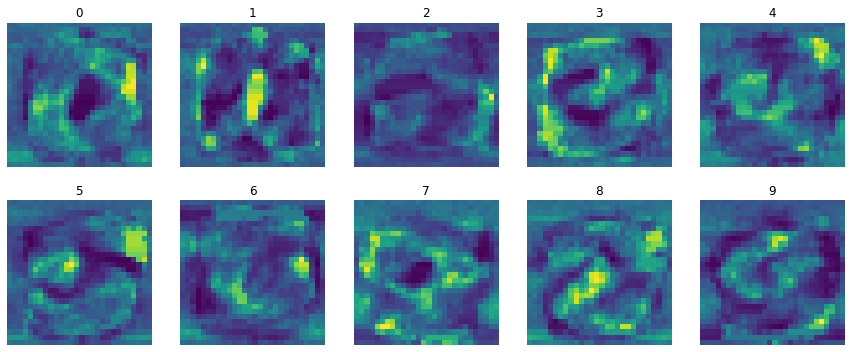

In [437]:
a = torch.full((10,28,28),0.0)
for i in range(10):
    for j in range(20):
        a[i] += weights2[i][j]*ims[j]
        
a = a.transpose(0,-1).clamp(a.sum((-1,-2))/784-a.std((-1,-2))*2,
                            a.sum((-1,-2))/784+a.std((-1,-2))*2).transpose(0,-1)

show_images(nn.Softmax(-1)(a), nrows=2, titles=range(10))

### WOAH!
I didn't expect it to be that pronounced, especially with how simply I got these images (though I did do a lot more after getting initial results - adding the softmax and the clamp really lets it shine)! Hopefully similar results are common to what I see now (try re-training until the accuracy exceeds 93%). Here's a screenshot of my particular results (the 3 is very clear!):

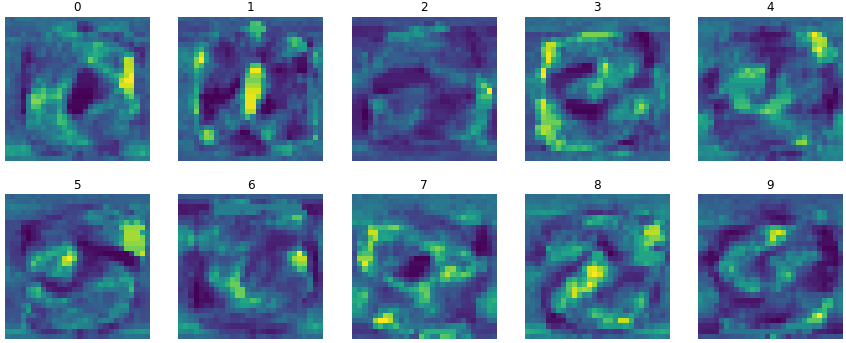

I'm really happy with my results so far, but although I'd like to experiment more and improve the model, especially with a convolutional network or data augmentation, I think it would be best for me to stop here and continue with the fastai lessons.